# Imports and functions

In [131]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt
from open_walk_analysis import *
import warnings
warnings.filterwarnings('ignore')

# Load data

In [56]:
def overlap(p,q):
    """Calculates the difference in overlap."""
    return np.array(abs(p - q)).sum() / (p.sum() + q.sum())

In [3]:
def top_path(G, source): 
    # Find moves away from center
    rings = ring_levels(G, source)
    # Get further derived sequences
    for i in range(7):
        if len(rings[i]) != 0:
            furthest = i 
    ends = rings[furthest] # only 6 moves away

    # Build a dictionary of node flux to 
    options = dict([(end, G.node[end]['flux']) for end in ends])

    sequences = np.array(list(options.keys()))
    fluxes = np.array(list(options.values()))

    # Find the highest flux sequence
    most_probable_node = np.argmax(fluxes)
    
    max_seq = sequences[most_probable_node]

    # Return that sequence
    return (source, max_seq)

In [128]:
def epistasis_between_pair(pair, target):
    """Calculate the epistasis between two sequences
    
    
    Returns
    -------
    epistasis : list
        magnitude of epistasis for each order. First element is the 
        additive terms, second is pairwise epistasis, so on...
    order : dict
        Keys are order of model used. Values are list of differences (theta) between 
        the known path probabilities and the simulated (using epistasis model) 
        at each mutational step away. 
    """
    # Prepare for GenotypePhenotypeMap
    wildtype = pair[0]
    length = len(wildtype)
    mutations = binary_mutations_map(*pair)

    # Determine the order of epistasis
    changes = find_differences(*pair)
    order = len(changes)

    c = Conformations(length)

    # Construct a genotype-phenotype map
    gpm = LatticeGenotypePhenotypeMap(wildtype, mutations=mutations, target_conf=target)
    #gpm.fold(Conformations=Conformations(length))
    gpm.fold(Conformations=Conformations(length))

    # Fit a high-order epistasis model
    model = EpistasisLinearRegression.from_gpm(gpm, order=order, model_type="local")
    model.fit()

    # Calculate the average magnitude of epistasis
    epistasis = []
    for i in range(1,order+1):
        z = model.epistasis.get_orders(i)
        epistasis.append(np.mean(np.abs(z.values)))

    # Model evolution in the map
    gpm.phenotype_type = "fracfolded"
    G = gpm.add_networkx()
    G.add_evolutionary_model(fixation)

    paths1 = enumerate_all_subpaths(G)

    # Build a predicted genotype-phenotype map from epistasis
    overlaps = {}
    for i in range(1, 8):
        # Get subset of epistasis
        em = model.epistasis.get_orders(*range(i))

        # Build map from epistatic coefs
        sim = NonlinearSimulation.from_coefs(
            wildtype, mutations, em.labels, em.values, 
            function=lambda x: 1 / (1 + np.exp(x)), 
            model_type="local")

        # Build a network
        Gsim = sim.add_networkx()

        # Model evolution in simulation
        Gsim.add_evolutionary_model(fixation)
        paths2 = enumerate_all_subpaths(Gsim)

        overlaps[i] = overlap_for_subpaths(paths1, paths2)

    return epistasis, overlaps

In [108]:
def enumerate_all_subpaths(G):
    """Enumerate all paths to all nodes in the network, G. Then, calculate their 
    flux.
    
    Parameter
    ---------
    G : networkx graph
        Graph with wildtype labeled as 0, and each edge has a `fixation` key.
    
    Returns
    -------
    paths : dict of dicts
        Keys are number of mutational steps, values are dictionaries that have the path
        mapped to the path's probability (product of fixation probabilties).
    
    Example
    -------
    paths = {
        1 : {(0,3): 0.6, (0,2): 0.4 ... }
        2 : {(0,3,6) : 0.51, (0,2,7), ... }
    }
    """        
    source = 0
    nodes = list(G.nodes())
    nodes.remove(source)
    
    # Begin enumerate paths to all nodes
    paths = dict([(i, {}) for i in range(1, 7)])
    for target in nodes:
        # enumerate all paths to a given target
        pathways = list(nx.all_shortest_paths(G, source, target))
        nmuts = len(pathways[0])-1
        
        # Get flux from all paths
        probabilities = {}
        for path in pathways:
            path = tuple(path)

            # Don't repeat any calcs, use old calc and 
            if nmuts > 1:
                current_prob = paths[nmuts-1][path[:nmuts]]
                new_move_prob = G.edge[path[-2]][path[-1]]["fixation"]

                # Calculate the probability of this new step
                pi = current_prob * new_move_prob
                probabilities[path] = pi
            else: 
                probabilities[path] = G.edge[path[-2]][path[-1]]["fixation"]
            
        # Add these paths/probs to paths dictionary.
        paths[nmuts].update(probabilities)
        
    return paths


def overlap_for_subpaths(paths1, paths2):
    """"""
    overlaps = []
    for nsteps in range(1, len(paths1)+1):
        pathways1 = paths1[nsteps]
        pathways2 = paths2[nsteps]
        # Built a spectrum of probabilities
        probs1 = np.array([pathways1[key] for key in pathways1.keys()])
        probs2 = np.array([pathways2[key] for key in pathways2.keys()])
        # Calculate overlap
        theta = overlap(probs1, probs2)
        overlaps.append(theta)
    return overlaps

In [142]:
dfluxes = dict([(i, []) for i in range(7)])
gpms = {}
targets = {}
folder = "two-state-predictions"


# Iterate through many datasets
for d in range(0, 100):
    
    with open(folder+"/results/walks-actual"+str(d)+".pickle", "rb") as f:
        data = pickle.load(f)
        edges0 = data["edges"]
        seq = data["seq"]
        target = data["target"]
        temp = data["temp"]

    with open(folder+"/results/walks-predicted2-"+str(d)+".pickle", "rb") as f:
        data = pickle.load(f)
        edges2 = data["edges"]   
    
    # Formulate as networks
    try:
        G0, G2, Gdiff = build_graphs(edges0, edges2, seq)
        rings = ring_levels(Gdiff, seq)

        # Add to summary statistic
        for ring, sequences in rings.items():

            if  ring < 7:

                diff, denom1, denom2 = 0, 0, 0
                for i in sequences:

                    # Add up total flux exchange, and the difference between two networks
                    for j in Gdiff.neighbors(i):

                        diff += Gdiff.edge[i][j]["weight"]
                        try: denom1 += G0.edge[i][j]["delta_flux"]
                        except: pass

                        try: denom2 += G2.edge[i][j]["delta_flux"]
                        except: pass

                denom = denom1 + denom2

                # Normalize the flux exchange at this hamming distance
                if denom != 0:
                    dfluxes[ring].append(diff/denom)
                elif diff == 0: pass
                else:
                    dfluxes[ring].append(0)

        gpms[d] = top_path(G0, seq)
        targets[d] = target
    except: pass

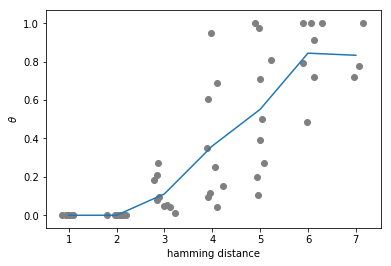

In [12]:
fig, ax = plt.subplots()
means = []
for key, val in dfluxes.items(): 
    #if key > 0:
    y = np.array(val)
    ymean = np.mean(y)
    x = np.ones(len(y)) * (key+1)
    xjitter = x + np.random.randn(len(x))* .1
    ax.scatter(xjitter,y, marker="o", color="gray", alpha=1)
    means.append(ymean)

x = range(1, 8)
y = means
ax.plot(x,y)
ax.set_xlabel("hamming distance")
ax.set_ylabel("$\\theta$")
#fig.savefig("/Users/Zsailer/Dropbox/epistasis-paper/02_he-comes-from-ensembles/figures/open-walk-divergence.pdf", format="pdf")

In [19]:
from gpmap.utils import binary_mutations_map, find_differences
from latticegpm import LatticeGenotypePhenotypeMap
from latticeproteins.conformations import Conformations, ConformationList
from epistasis.models import EpistasisLinearRegression
from epistasis.simulate import NonlinearSimulation
from gpmap.evolve.models import fixation
from gpmap.graph.draw import network
from gpmap.graph.paths import paths_and_probabilities

In [124]:
pair = gpms[0]
target = targets[0]
wildtype = pair[0]
length = len(wildtype)
mutations = binary_mutations_map(*pair)

# Determine the order of epistasis
changes = find_differences(*pair)
order = len(changes)

c = Conformations(length)

# Construct a genotype-phenotype map
gpm = LatticeGenotypePhenotypeMap(wildtype, mutations=mutations, target_conf=target)
#gpm.fold(Conformations=Conformations(length))
gpm.fold(Conformations=Conformations(length))

# Fit a high-order epistasis model
model = EpistasisLinearRegression.from_gpm(gpm, order=order, model_type="local")
model.fit()

# Calculate the average magnitude of epistasis
epistasis = []
for i in range(1,order+1):
    z = model.epistasis.get_orders(i)
    epistasis.append(np.mean(np.abs(z.values)))

# Model evolution in the map
gpm.phenotype_type = "fracfolded"
G = gpm.add_networkx()
G.add_evolutionary_model(fixation)

paths1 = enumerate_all_subpaths(G)

# Build a predicted genotype-phenotype map from epistasis
overlaps = {}
for i in range(1, 8):
    # Get subset of epistasis
    em = model.epistasis.get_orders(*range(i))
    
    # Build map from epistatic coefs
    sim = NonlinearSimulation.from_coefs(
        wildtype, mutations, em.labels, em.values, 
        function=lambda x: 1 / (1 + np.exp(x)), 
        model_type="local")
    
    # Build a network
    Gsim = sim.add_networkx()
    
    # Model evolution in simulation
    Gsim.add_evolutionary_model(fixation)
    paths2 = enumerate_all_subpaths(Gsim)
    
    overlaps[i] = overlap_for_subpaths(paths1, paths2)
    

/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)


In [125]:
overlaps

{1: [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]],
 2: [[9.9229216502683291e-15, 0.11445275556717453, 1.0, 1.0, 1.0, 1.0]],
 3: [[9.9229216502683291e-15,
   2.4669983044756469e-14,
   0.2630971295161928,
   0.49949585760172049,
   0.67593125731149983,
   0.7387704077402989]],
 4: [[9.9229216502683291e-15,
   2.4669983044756469e-14,
   1.6718577832717606e-14,
   0.01849823908249975,
   0.45321671041405709,
   0.3986543097248636]],
 5: [[9.9229216502683291e-15,
   2.4669983044756469e-14,
   1.6718577832717606e-14,
   3.6164463299036455e-14,
   0.036749533809493307,
   0.085777236846338686]],
 6: [[9.9229216502683291e-15,
   2.4669983044756469e-14,
   1.6718577832717606e-14,
   3.6164463299036455e-14,
   4.2358626796525121e-14,
   0.0019705661531659135]],
 7: [[9.9229216502683291e-15,
   2.4669983044756469e-14,
   1.6718577832717606e-14,
   3.6164463299036455e-14,
   4.2358626796525121e-14,
   3.61934623980356e-14]]}

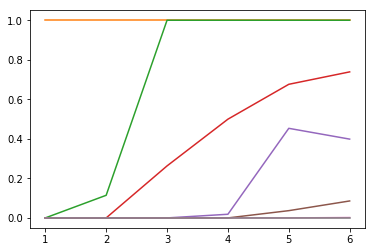

In [126]:
fig, ax = plt.subplots()
for nsteps, lines in overlaps.items():
    for line in lines:
        ax.plot(range(1,7), line, color="C"+str(nsteps))

In [129]:
gpms.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [130]:
magn_epistasis = np.ones((100, 6), dtype=float) * np.nan
overlaps = dict([(i, []) for i in range(1, 8)])

for key, pair in gpms.items():
    epist, over = epistasis_between_pair(pair, targets[key])
    magn_epistasis[key, :len(epist)] = epist

    for order in over:
        overlaps[order].append(over[order])   


/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)
/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)
/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)
/Users/Zsailer/.virtualenvs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)
/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)
/Users/Zsailer/.virtualenvs/py3/lib/python

/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)
/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)
/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)
/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)
/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)
/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)
/Users/Zsailer/.virtualenvs/

/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)
/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)
/Users/Zsailer/.virtualenvs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)
/Users/Zsailer/.virtualenvs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/Users/Zsailer/Documents/Research/projects/pkgs/gpmap/gpmap/evolve/models.py:13: RuntimeWarning: overflow encountered in exp
  denominator = 1 - np.exp(-N * sij)
/Users/Zsailer/.virtualenvs/py3/lib/python3.5/site-packa

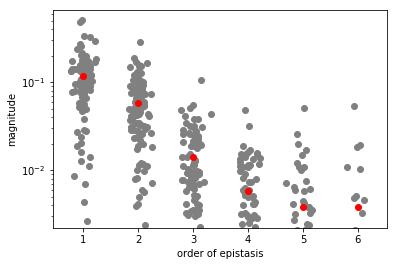

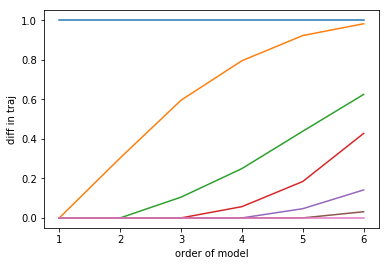

In [141]:
fig, ax = plt.subplots()
for i in range(len(magn_epistasis)):
    y = magn_epistasis[i]
    x = np.arange(1, len(y)+1) + np.random.randn(len(y))*.1 
    ax.scatter(x, y, color='gray')

meanx = np.arange(1, 7)
meany = np.nanmean(magn_epistasis, axis=0)
ax.plot(meanx, meany, 'ro')
ax.set_yscale('log')
ax.set_xlabel("order of epistasis")
ax.set_ylabel("magnitude")


fig, ax = plt.subplots()
for i in range(1, len(overlaps)+1):
    y = np.array(overlaps[i])
    ymean = np.nanmean(y, axis=0)
    x = np.arange(1, len(ymean)+1)# + np.random.randn(len(ymean))*.1 
    ax.plot(x, ymean, color='C' + str(i-1))

#meanx = np.arange(1, 7)
#meany = np.nanmean(overlaps, axis=0)
#ax.plot(meanx, meany, 'ro')
#ax.set_yscale('log')
ax.set_xlabel("order of model")
ax.set_ylabel("diff in traj")
#fig.savefig("/Users/Zsailer/Dropbox/epistasis-paper/02_he-comes-from-ensembles/figures/magnitude_of_epistasis.pdf", format="pdf")